# Deep Knowledge Tracing with ModernBERT

This notebook demonstrates our approach to simulating student responses in an educational platform using **Deep Knowledge Tracing (DKT)** with **ModernBERT**. Each student is treated as a unique case, and we fine-tune separate ModernBERT models per student. The key goal is to predict whether a student will answer a given question correctly or incorrectly based on:

- The text of the question and its multiple-choice options.
- The topic, subject, and other relevant attributes.
- The student's past performance (implicitly learned during training).

Our broader objective is to create synthetic "student models" that can help us estimate question difficulty without requiring costly large-scale field testing with real students.

## Notebook Overview
1. **Imports and Environment Setup**: We load environment variables and import the required Python libraries.
2. **Data Loading and Preparation**: We read the main dataset, remove duplicates, and prepare it for training.
3. **User Selection**: We select the top 50 users based on the number of answers submitted.
4. **Model Training Function**: We define a function that fine-tunes a ModernBERT model for a specific user.
5. **Batch Training**: We loop over the selected users and fine-tune a separate model for each.
6. **Next Steps**: Outline potential next steps, such as evaluating performance, computing difficulty metrics, etc.

In [2]:
# 1) Imports and Environment Setup

from dotenv import load_dotenv  # For loading environment variables from a .env file
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load environment variables
load_dotenv()

print("[INFO] Environment variables loaded and libraries imported.")

[INFO] Environment variables loaded and libraries imported.


### Data Loading
In this section, we load the main dataset that contains all the user interactions (student answers to questions). We remove duplicate entries (if any) to ensure that each `answer_id` is unique. This step helps maintain data quality.

In [3]:
# 2) Data Loading and Preparation

# Load the master dataset that has the translated version of all records
df_original = pd.read_csv('../data/new/master_translated.csv')
print(f"[INFO] Loaded master dataset with {len(df_original):,} rows.")

# Drop duplicate answer_ids to ensure each answer is only counted once
initial_count = len(df_original)
df_original.drop_duplicates(subset=['answer_id'], inplace=True)
final_count = len(df_original)
print(f"[INFO] Duplicates removed: {initial_count - final_count}")
print(f"[INFO] Dataset now has {final_count:,} rows.")

[INFO] Loaded master dataset with 269,171 rows.
[INFO] Duplicates removed: 0
[INFO] Dataset now has 269,171 rows.


### User Selection
We next identify the top 50 users based on the number of answers submitted. These top users are chosen for individual model training, which will allow us to capture a variety of response patterns from different individuals.

In [5]:
# 3) Selecting the top 50 users by answer count

# Count how many answers each user has
user_answer_counts = df_original['user_id'].value_counts()

# Select the top 50
top_50_users = user_answer_counts.head(50)

# (Optional) Reverse the order, so you process from smallest to largest if you prefer
top_50_users = top_50_users.iloc[::-1]

print("[INFO] Top 50 users by number of answers:")
for u_id, count in top_50_users.items():
    print(f"- User {u_id}: {count:,} answers")

[INFO] Top 50 users by number of answers:
- User 22606: 501 answers
- User 32329: 509 answers
- User 22853: 510 answers
- User 51978: 520 answers
- User 16297: 525 answers
- User 52981: 532 answers
- User 52584: 533 answers
- User 22601: 536 answers
- User 50149: 537 answers
- User 53005: 539 answers
- User 52977: 542 answers
- User 51618: 546 answers
- User 52913: 546 answers
- User 16289: 551 answers
- User 52995: 553 answers
- User 51184: 569 answers
- User 52171: 576 answers
- User 52979: 576 answers
- User 52989: 594 answers
- User 53024: 596 answers
- User 52912: 602 answers
- User 52991: 615 answers
- User 30844: 634 answers
- User 52295: 644 answers
- User 52174: 646 answers
- User 52423: 649 answers
- User 52937: 653 answers
- User 52311: 676 answers
- User 23076: 685 answers
- User 52167: 694 answers
- User 52914: 696 answers
- User 52645: 702 answers
- User 52209: 720 answers
- User 52173: 742 answers
- User 52407: 749 answers
- User 51986: 760 answers
- User 53007: 804 answ

In [6]:
# Save top 50 users to CSV
top_50_users_df = pd.DataFrame({
    'user_id': top_50_users.index,
    'answer_count': top_50_users.values
})
top_50_users_df.to_csv('top_50_users.csv', index=False)
print("[INFO] Saved top 50 users to top_50_users.csv")


[INFO] Saved top 50 users to top_50_users.csv


### Model Training Setup
Below, we install all necessary libraries and define the function that trains a **ModernBERT** model for a single user. We use Hugging Face Transformers to:

1. **Tokenize** our question text + multiple-choice options.
2. **Fine-tune** a ModernBERT-based binary classifier.
3. **Evaluate** performance (using a weighted F1 score, which is important because the dataset can be imbalanced).

Key libraries and components:
- **Datasets**: For handling train/validation splits in a memory-efficient manner.
- **AutoTokenizer** and **AutoModelForSequenceClassification**: Automatically load the correct tokenizer and model configuration.
- **Trainer** and **TrainingArguments**: Simplify the training loop, logging, checkpointing, and evaluation.

In [ ]:
# 4) Model Definition and Utility Imports

from sklearn.model_selection import train_test_split

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from transformers.trainer_utils import get_last_checkpoint
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

print("[INFO] Transformers and related libraries loaded.")

### Train a Model for One User
The following function, `train_user_model`, encapsulates all the steps for training a ModernBERT model on data from a single user. The pipeline:

1. **Filter** the DataFrame to retrieve only rows belonging to the target user.
2. **Combine** the question text, the multiple-choice options, and meta-info (topic, subject, axis) into one string.
3. **Split** the user's data into train/test sets.
4. **Tokenize** the text for ModernBERT.
5. **Initialize** and **train** the model (using the Hugging Face Trainer).
6. **Evaluate** using a weighted F1 metric.
7. **Save** the best checkpoint.

If `push_to_hub=True`, the final model can be automatically uploaded to the Hugging Face Hub.

In [7]:
def train_user_model(
    df: pd.DataFrame,
    user_id: int,
    model_name: str = "answerdotai/ModernBERT-base",
    output_dir_base: str = "user_models",
    push_to_hub: bool = False,
    hub_repo_org: str = None,
    hub_token: str = None,
    num_train_epochs: int = 5,
    batch_size: int = 4
):
    """
    Trains a ModernBERT model to predict if a user will answer correctly.

    Args:
        df (pd.DataFrame): The entire dataset containing rows for all users.
        user_id (int): The target user's identifier.
        model_name (str): Hugging Face model ID for ModernBERT.
        output_dir_base (str): Base directory where user-specific checkpoints will be stored.
        push_to_hub (bool): Whether to push the final model to the Hugging Face Hub.
        hub_repo_org (str): Org or username for HF Hub repositories.
        hub_token (str): Personal access token if required for private repos.
        num_train_epochs (int): Number of epochs to train.
        batch_size (int): Training batch size.
    """

    # 1) Filter user data
    df_user = df[df["user_id"] == user_id].copy()

    # Check if user has any data
    if df_user.empty:
        print(f"[User {user_id}] No data. Skipping.")
        return

    # Convert correctness to integer labels (0/1)
    df_user["label"] = df_user["is_correct"].astype(int)

    # 2) Combine text: question + choices + topics
    def combine_text(row):
        q = str(row.get("question_title", ""))
        a = str(row.get("option_a", ""))
        b = str(row.get("option_b", ""))
        c = str(row.get("option_c", ""))
        d = str(row.get("option_d", ""))
        e = str(row.get("option_e", ""))
        topic = str(row.get("topic_name", ""))
        subj = str(row.get("subject_name", ""))
        axis = str(row.get("axis_name", ""))

        return (
            f"Topic: {topic}\n"
            f"Subject: {subj}\n"
            f"Axis: {axis}\n\n"
            f"Question: {q}\n"
            f"A) {a}\n"
            f"B) {b}\n"
            f"C) {c}\n"
            f"D) {d}\n"
            f"E) {e}"
        )

    df_user["text"] = df_user.apply(combine_text, axis=1)

    # 3) Train/Test split
    train_df, test_df = train_test_split(
        df_user,
        test_size=0.2,
        shuffle=True,
        random_state=42
    )

    # Check if split is valid
    if train_df.empty or test_df.empty:
        print(f"[User {user_id}] Not enough data to split. Skipping.")
        return

    # Build Hugging Face Datasets
    train_dataset_hf = Dataset.from_pandas(train_df[["text","label"]].reset_index(drop=True))
    test_dataset_hf  = Dataset.from_pandas(test_df[["text","label"]].reset_index(drop=True))

    ds_dict = DatasetDict({
        "train": train_dataset_hf,
        "test": test_dataset_hf
    })

    # 4) Tokenize
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize_fn(batch):
        return tokenizer(
            batch["text"],
            padding="max_length",
            truncation=True,
            max_length=512
        )

    ds_dict = ds_dict.map(tokenize_fn, batched=True)

    # 5) Load Model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    )
    model.config.problem_type = "single_label_classification"

    # 6) Training Arguments
    user_output_dir = os.path.join(output_dir_base, f"user_{user_id}")
    os.makedirs(user_output_dir, exist_ok=True)

    if push_to_hub:
        if hub_repo_org:
            hub_repo_id = f"{hub_repo_org}/modernbert-user-{user_id}"
        else:
            hub_repo_id = f"modernbert-user-{user_id}"
    else:
        hub_repo_id = None

    training_args = TrainingArguments(
        output_dir=user_output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        use_mps_device=True,          # For Apple Silicon
        bf16=True,                    # Use bfloat16 if supported
        optim="adamw_torch_fused",   # Fused optimizer for performance
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        save_total_limit=2,
        push_to_hub=push_to_hub,
        hub_model_id=hub_repo_id,
        hub_token=hub_token,
        hub_strategy="end",
    )

    # Define metrics
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        acc = accuracy_score(labels, preds)
        f1_val = f1_score(labels, preds, average="weighted")
        return {"accuracy": acc, "f1": f1_val}

    # 7) Create Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=ds_dict["train"],
        eval_dataset=ds_dict["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Check if we should resume training
    last_checkpoint = None
    if os.path.isdir(user_output_dir):
        last_checkpoint = get_last_checkpoint(user_output_dir)
    if last_checkpoint is not None:
        print(f"[User {user_id}] Resuming from {last_checkpoint}.")
    else:
        print(f"[User {user_id}] Starting training from scratch.")

    # 8) Train
    trainer.train(resume_from_checkpoint=last_checkpoint)

    # Evaluate final
    eval_metrics = trainer.evaluate()
    print(f"[User {user_id}] Final eval metrics: {eval_metrics}")

    # 9) Save the best checkpoint
    trainer.save_model(user_output_dir)
    print(f"[User {user_id}] Done! Best model saved at: {user_output_dir}.")

### Train Models for the Top 50 Users
Now we iterate over the selected top 50 users and train a separate ModernBERT model for each. This step can be time-consuming depending on your hardware and the amount of data per user.

> **Note**: The loop below is configured with `push_to_hub=True`, so if you set up your Hugging Face credentials and tokens in the environment, the models will be uploaded to your account or organization repository. You can set this to `False` if you only want to train locally.

In [ ]:
# 5) Batch Training for Top Users

OUTPUT_DIR_BASE = "user_models"  # Local directory for saving user-specific model checkpoints

for user_id, count in top_50_users.items():
    print(f"\n=== Training model for User {user_id} (Answers = {count}) ===")
    train_user_model(
        df=df_original,
        user_id=user_id,
        model_name="answerdotai/ModernBERT-base",
        output_dir_base=OUTPUT_DIR_BASE,
        push_to_hub=True,  # Set to False if you don't want to push to Hugging Face Hub
        hub_token=os.getenv("HUGGINGFACE_ACCESS_TOKEN"),
        num_train_epochs=10,
        batch_size=4
    )

### Selecting the questions

In [7]:
df_original = pd.read_csv('../data/new/master_translated.csv')
top_50_users = pd.read_csv('top_50_users.csv')


# Get all unique question IDs
all_questions = set(df_original['question_id'].unique())

# Get question IDs answered by top 50 users
questions_by_top_users = set(df_original[df_original['user_id'].isin(top_50_users.keys())]['question_id'].unique())

# Find question IDs not answered by top 50 users
unanswered_questions = all_questions - questions_by_top_users

print(f"Total unique questions: {len(all_questions)}")
print(f"Questions answered by top 50 users: {len(questions_by_top_users)}")
print(f"Questions not answered by top 50 users: {len(unanswered_questions)}")

# Convert to DataFrame for easier handling if needed
df_unanswered = pd.DataFrame(list(unanswered_questions), columns=['question_id'])


Total unique questions: 9769
Questions answered by top 50 users: 0
Questions not answered by top 50 users: 9769



Answer statistics for top 30 most answered questions:
Average answers per question: 93.29
Median answers per question: 76.00
Min answers: 45
Max answers: 366


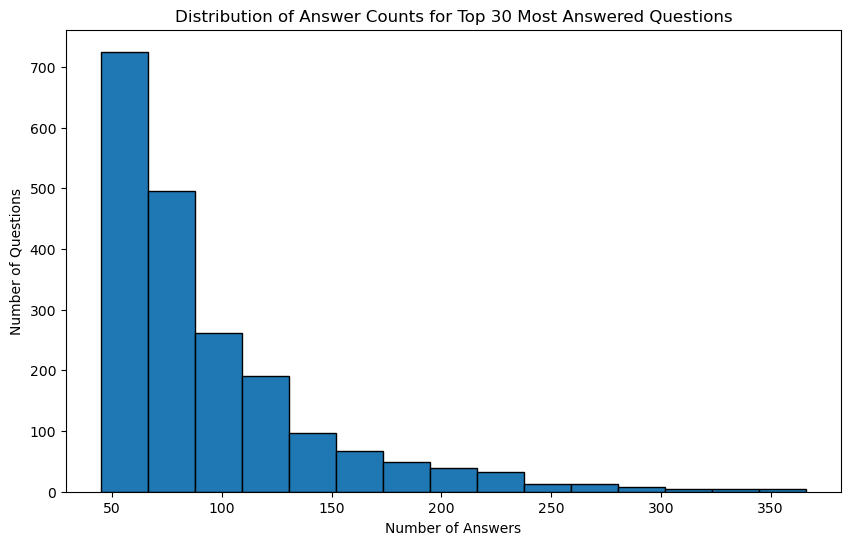

In [18]:
# Get the 30 questions with the most answers
answer_counts = df_original['question_id'].value_counts()
top_400_questions = answer_counts.head(2000).index

# Get answer statistics for top 30 questions
top_400_answer_counts = answer_counts[top_400_questions]

print(f"\nAnswer statistics for top 30 most answered questions:")
print(f"Average answers per question: {top_400_answer_counts.mean():.2f}")
print(f"Median answers per question: {top_400_answer_counts.median():.2f}")
print(f"Min answers: {top_400_answer_counts.min()}")
print(f"Max answers: {top_400_answer_counts.max()}")

# Show distribution of answer counts
plt.figure(figsize=(10, 6))
plt.hist(top_400_answer_counts, bins=15, edgecolor='black')
plt.title('Distribution of Answer Counts for Top 30 Most Answered Questions')
plt.xlabel('Number of Answers')
plt.ylabel('Number of Questions')
plt.show()


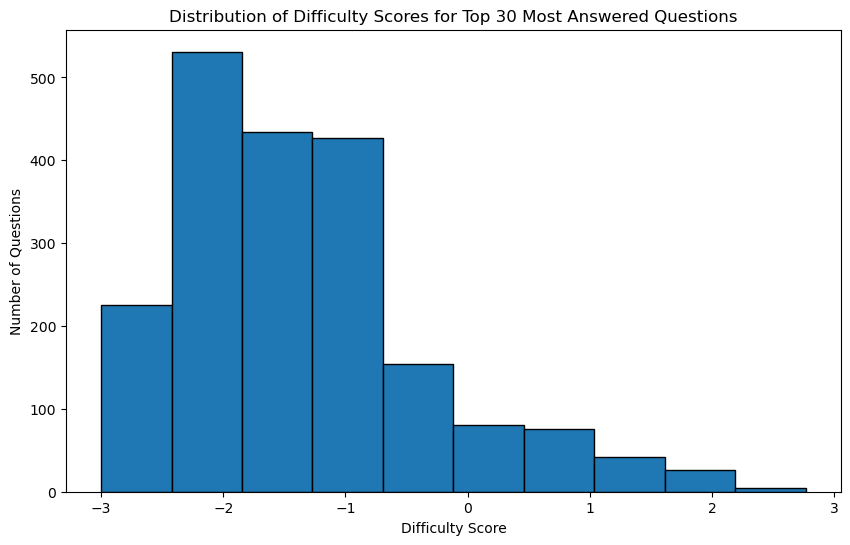


Difficulty statistics for top 30 most answered questions:
Average difficulty: -1.37
Median difficulty: -1.48
Min difficulty: -3.00
Max difficulty: 2.77


In [19]:
# Get difficulty scores for top 30 questions
top_400_difficulties = df_original[df_original['question_id'].isin(top_400_questions)]['difficulty'].unique()

# Create mapping of question_id to difficulty
question_difficulty_map = df_original[['question_id', 'difficulty']].drop_duplicates().set_index('question_id')
top_400_difficulties = question_difficulty_map.loc[top_400_questions]['difficulty']

plt.figure(figsize=(10, 6))
plt.hist(top_400_difficulties, bins=10, edgecolor='black')
plt.title('Distribution of Difficulty Scores for Top 30 Most Answered Questions')
plt.xlabel('Difficulty Score')
plt.ylabel('Number of Questions')
plt.show()

print(f"\nDifficulty statistics for top 30 most answered questions:")
print(f"Average difficulty: {top_400_difficulties.mean():.2f}")
print(f"Median difficulty: {top_400_difficulties.median():.2f}")
print(f"Min difficulty: {top_400_difficulties.min():.2f}")
print(f"Max difficulty: {top_400_difficulties.max():.2f}")


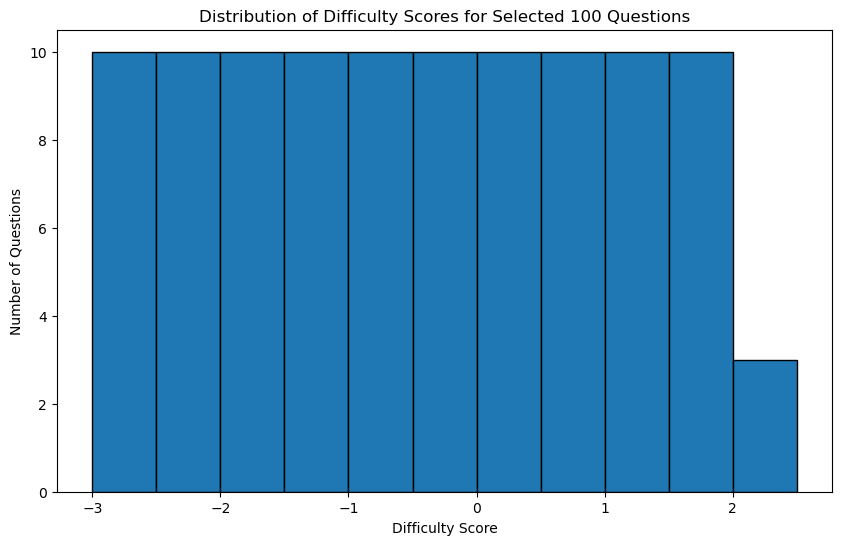


Difficulty statistics for selected 100 questions:
Average difficulty: -0.44
Median difficulty: -0.32
Min difficulty: -2.99
Max difficulty: 2.30


In [25]:
import numpy as np
# Create a dataframe with question_id and difficulty for top 400 questions
question_diff_df = pd.DataFrame({
    'question_id': top_400_questions,
    'difficulty': top_400_difficulties
})

# Create difficulty bins from -3 to 2 in 0.5 increments
bins = np.arange(-3, 3, 0.5)
question_diff_df['diff_bin'] = pd.cut(question_diff_df['difficulty'], bins=bins, labels=False)

# Try to select 10 questions from each bin to get 100 total questions
selected_questions = []
for bin_num in range(len(bins)-1):
    bin_questions = question_diff_df[question_diff_df['diff_bin'] == bin_num]
    if len(bin_questions) > 0:  # Only sample if bin has questions
        selected = bin_questions.sample(min(10, len(bin_questions)))
        selected_questions.append(selected)

final_selection = pd.concat(selected_questions)
selected_100_questions = final_selection['question_id'].values

# Verify distribution of difficulties for selected questions
selected_difficulties = question_difficulty_map.loc[selected_100_questions]['difficulty']

plt.figure(figsize=(10, 6))
plt.hist(selected_difficulties, bins=bins, edgecolor='black')
plt.title('Distribution of Difficulty Scores for Selected 100 Questions')
plt.xlabel('Difficulty Score')
plt.ylabel('Number of Questions')
plt.show()

print(f"\nDifficulty statistics for selected 100 questions:")
print(f"Average difficulty: {selected_difficulties.mean():.2f}")
print(f"Median difficulty: {selected_difficulties.median():.2f}")
print(f"Min difficulty: {selected_difficulties.min():.2f}")
print(f"Max difficulty: {selected_difficulties.max():.2f}")


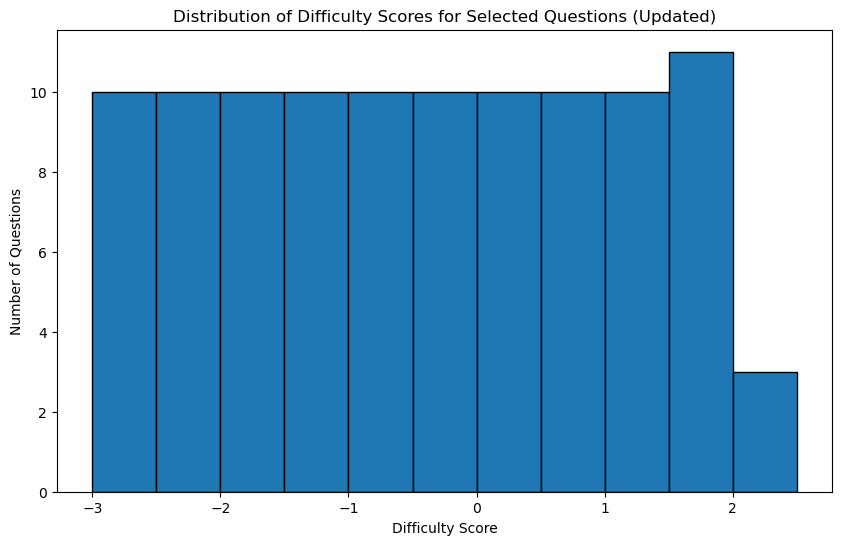


Difficulty statistics for selected questions after adding extreme cases:
Average difficulty: -0.41
Median difficulty: -0.30
Min difficulty: -2.99
Max difficulty: 2.30


In [26]:
# Add one question from -2.5 to -2 bin and one from 1.5 to 2 bin
extreme_bins = [(1.5, 2)]
additional_questions = []

for low, high in extreme_bins:
    # Find questions in this difficulty range from top 400
    bin_questions = question_diff_df[
        (question_diff_df['difficulty'] >= low) & 
        (question_diff_df['difficulty'] < high)
    ]
    if len(bin_questions) > 0:
        selected = bin_questions.sample(1)
        additional_questions.append(selected)

# Add the new questions to our selection
if additional_questions:
    additional_selection = pd.concat(additional_questions)
    selected_100_questions = np.concatenate([
        selected_100_questions,
        additional_selection['question_id'].values
    ])

# Verify updated distribution
selected_difficulties = question_difficulty_map.loc[selected_100_questions]['difficulty']

plt.figure(figsize=(10, 6))
plt.hist(selected_difficulties, bins=bins, edgecolor='black')
plt.title('Distribution of Difficulty Scores for Selected Questions (Updated)')
plt.xlabel('Difficulty Score')
plt.ylabel('Number of Questions')
plt.show()

print(f"\nDifficulty statistics for selected questions after adding extreme cases:")
print(f"Average difficulty: {selected_difficulties.mean():.2f}")
print(f"Median difficulty: {selected_difficulties.median():.2f}")
print(f"Min difficulty: {selected_difficulties.min():.2f}")
print(f"Max difficulty: {selected_difficulties.max():.2f}")

In [27]:
# Get full question information for selected questions
selected_questions = df_original[df_original['question_id'].isin(selected_100_questions)][
    ['question_id', 'question_title', 'option_a', 'option_b', 'option_c', 'option_d', 'option_e',
     'difficulty', 'topic_name', 'subject_name', 'axis_name']
]

# Remove duplicate rows based on question_id
selected_questions = selected_questions.drop_duplicates(subset=['question_id'])


print("\nSelected questions information:")
print(f"Total questions: {len(selected_questions)}")
print("\nSample of the selected questions:")
print(selected_questions.head().to_string())

# Save detailed information about distribution across subjects, topics, and axes
print("\nDistribution across subjects:")
print(selected_questions['subject_name'].value_counts())

print("\nDistribution across topics:")
print(selected_questions['topic_name'].value_counts())

print("\nDistribution across axes:")
print(selected_questions['axis_name'].value_counts())




Selected questions information:
Total questions: 104

Sample of the selected questions:
     question_id                                                                                                      question_title   option_a   option_b   option_c   option_d   option_e  difficulty                               topic_name      subject_name axis_name
20         22867                                                                                          How much is `1903 ÷ 11`?      `173`      `183`      `172`      `174`        `175`    1.448133              Division of natural numbers   Natural Numbers   Numbers
42         22869                                                                         What do you get when solving `1936 ÷ 11`?      `186`      `177`      `178`      `176`        `175`    1.385074              Division of natural numbers   Natural Numbers   Numbers
121        15655                                                            <div>What is the value of `3

In [28]:
# Save selected questions to CSV for later reference
selected_questions.to_csv('selected_questions.csv', index=False)
print("\nSaved selected questions to 'selected_questions.csv'")



Saved selected questions to 'selected_questions.csv'


### Getting the student responses

In [29]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load selected questions from CSV
selected_questions = pd.read_csv('selected_questions.csv')
top_50_users = pd.read_csv('top_50_users.csv')


# ------------------------------------------------------------------
# 1) HELPER FUNCTIONS
# ------------------------------------------------------------------

def create_question_text(row):
    """
    Given a row from df_selected_questions, build the same text format
    used in training (question + choices + topic/subject/axis).
    """
    question_text = str(row.get("question_title", ""))
    a = str(row.get("option_a", ""))
    b = str(row.get("option_b", ""))
    c = str(row.get("option_c", ""))
    d = str(row.get("option_d", ""))
    e = str(row.get("option_e", ""))  # might be empty if only 4 options

    topic = str(row.get("topic_name", ""))
    subject = str(row.get("subject_name", ""))
    axis = str(row.get("axis_name", ""))

    text = (
        f"Topic: {topic}\n"
        f"Subject: {subject}\n"
        f"Axis: {axis}\n\n"
        f"Question: {question_text}\n"
        f"A) {a}\n"
        f"B) {b}\n"
        f"C) {c}\n"
        f"D) {d}\n"
        f"E) {e}"
    )
    return text

def predict_is_correct(model, tokenizer, question_row: dict) -> int:
    """
    Uses a pre-loaded model to predict if a question will be answered correctly.
    
    Args:
        model: Pre-loaded ModernBERT model
        tokenizer: Pre-loaded tokenizer
        question_row: dict with question data
    Returns:
        int: 0 (incorrect) or 1 (correct)
    """
    # 1. Prepare input
    text = create_question_text(question_row)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    
    # 2. Forward pass -> logits
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    
    return pred

# ------------------------------------------------------------------
# 2) MAIN LOGIC: BUILD THE (50 × 30) MATRIX
# ------------------------------------------------------------------

def build_predictions_matrix(df_selected_questions, top_50_users):
    """
    For each user in top_50_users, load the HF model, then for each of
    the 30 questions in df_selected_questions, predict correctness.
    
    Returns:
      - predictions_matrix: numpy array of shape (50, 30),
        where predictions_matrix[i, j] is 0 or 1.
      - user_ids_list: list of user IDs in the same order as the matrix rows
      - question_ids: list of question IDs in the same order as the matrix columns
    """
    # Convert top_50_users to a list if it's not already
    if isinstance(top_50_users, pd.Series):
        user_ids_list = top_50_users.index.tolist()
    elif isinstance(top_50_users, pd.DataFrame):
        user_ids_list = top_50_users["user_id"].tolist()
    elif isinstance(top_50_users, (list, np.ndarray)):
        user_ids_list = list(top_50_users)
    else:
        raise ValueError("top_50_users must be list-like or a Series/DataFrame column")

    n_users = len(user_ids_list)
    n_questions = len(df_selected_questions)

    # We'll store the predictions in a 2D numpy array
    predictions_matrix = np.zeros((n_users, n_questions), dtype=int)

    # Get the actual question IDs
    question_ids = df_selected_questions['question_id'].tolist()

    # Loop over each user
    for i, uid in enumerate(user_ids_list):
        model_name_hf = f"matiashoyl/modernbert-user-{uid}"
        
        print(f"\n=== Loading model for user {uid}: {model_name_hf} ===")
        # Load model and tokenizer once per user
        tokenizer = AutoTokenizer.from_pretrained(model_name_hf)
        model = AutoModelForSequenceClassification.from_pretrained(model_name_hf)
        model.eval()
        
        # For each question
        for j, q_id in enumerate(question_ids):
            # Get the question row using question_id
            question_dict = df_selected_questions[df_selected_questions['question_id'] == q_id].iloc[0].to_dict()
            pred_label = predict_is_correct(model, tokenizer, question_dict)
            predictions_matrix[i, j] = pred_label
            print(f"[User {uid}] Done predicting question {q_id}")
        
        print(f"[User {uid}] Done predicting on {n_questions} questions.")
        
        # Clean up to free memory
        del model
        del tokenizer
        torch.cuda.empty_cache()  # If using GPU
    
    return predictions_matrix, user_ids_list, question_ids

# ------------------------------------------------------------------
# 3) EXAMPLE USAGE
# ------------------------------------------------------------------

# Build the matrix
pred_matrix, user_ids_list, question_ids = build_predictions_matrix(
    df_selected_questions=selected_questions, 
    top_50_users=top_50_users
)

print("\n== Finished building predictions matrix! ==\n")
print("Matrix shape:", pred_matrix.shape)  # Expect (50, 30)

# Save as numpy array
np.save("predictions_matrix.npy", pred_matrix)

# Create DataFrame with question IDs as columns and save to CSV
df_out = pd.DataFrame(
    data=pred_matrix,
    index=user_ids_list,
    columns=question_ids
)
df_out.to_csv("predictions_matrix.csv")

print("Saved predictions to predictions_matrix.npy and CSV!")


=== Loading model for user 22606: matiashoyl/modernbert-user-22606 ===
[User 22606] Done predicting question 22867
[User 22606] Done predicting question 22869
[User 22606] Done predicting question 15655
[User 22606] Done predicting question 27350
[User 22606] Done predicting question 23427
[User 22606] Done predicting question 26253
[User 22606] Done predicting question 24701
[User 22606] Done predicting question 21133
[User 22606] Done predicting question 16367
[User 22606] Done predicting question 27884
[User 22606] Done predicting question 25540
[User 22606] Done predicting question 22208
[User 22606] Done predicting question 25660
[User 22606] Done predicting question 27498
[User 22606] Done predicting question 22214
[User 22606] Done predicting question 22936
[User 22606] Done predicting question 16002
[User 22606] Done predicting question 16151
[User 22606] Done predicting question 23544
[User 22606] Done predicting question 24932
[User 22606] Done predicting question 26340
[Use

### Computing the IRT parameters


Question Parameter Statistics:
Average IRT Difficulty: 1.5313421029312504e-17
Std Dev IRT Difficulty: 1.0
Average Discrimination: 2.0955548095145655
Std Dev Discrimination: 0.28451663485465106

Student Ability Statistics:
Average Ability: 4.218847493575595e-17
Std Dev Ability: 1.0


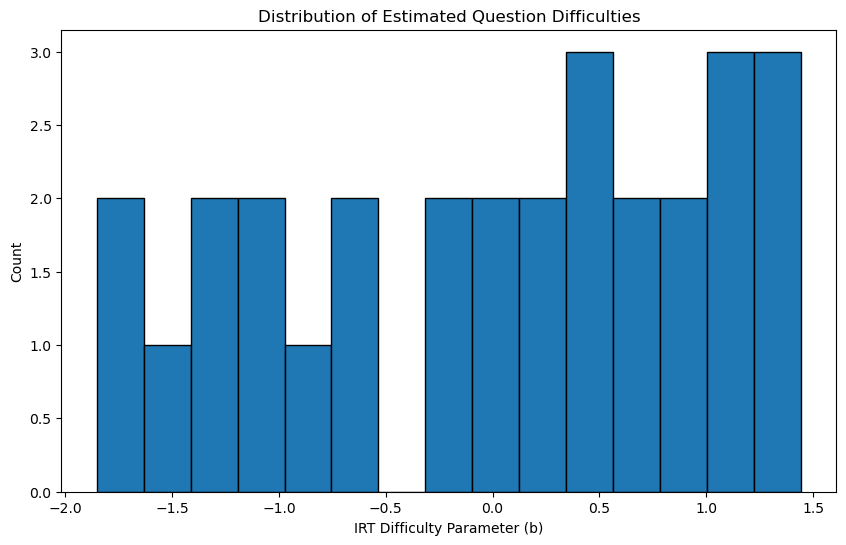

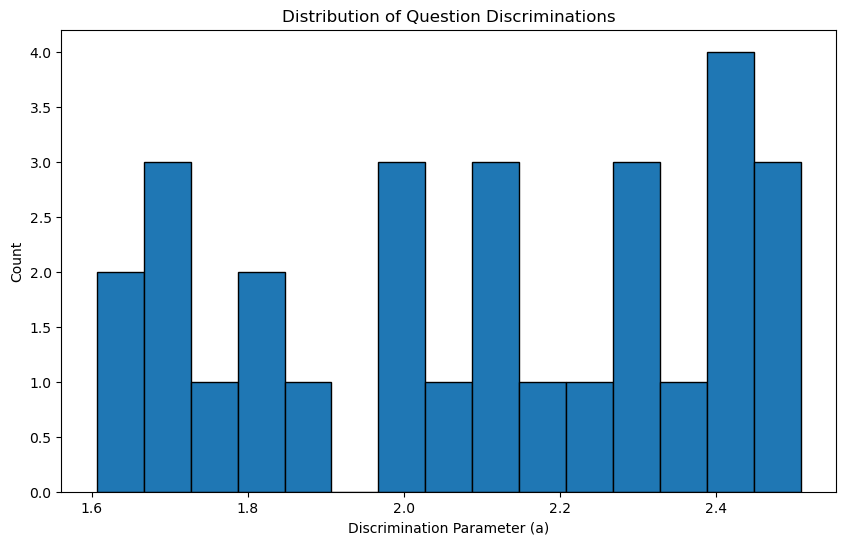

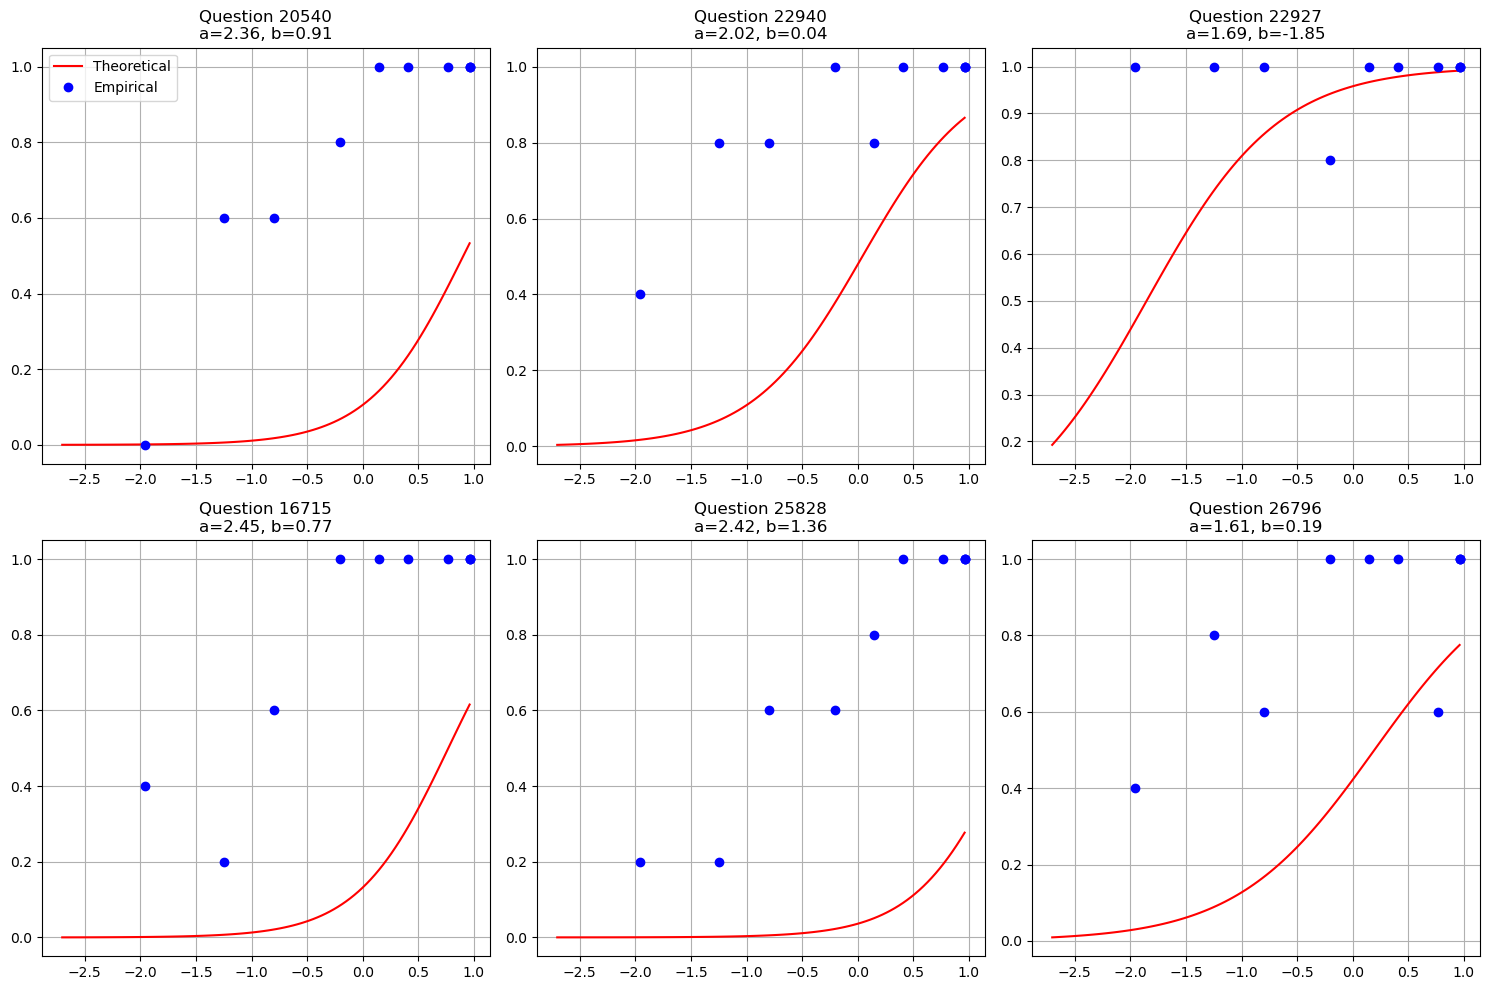


Correlation between ability estimates and total correct: 0.9646639635567897

5 Most Difficult Questions:
    question_id                                     question_title  \
13        26315  Factor the following expression `216a^3+8`:<br...   
4         25828  In a mixed class of `40` students, how many gi...   
26        16787  <div>If the length of a rectangle is `x`, and ...   
20        16685  <div>What is the value of the double of the so...   
18        16385  <div>What is the value of `(-1)^3 + (-1)^2 - (...   

    irt_difficulty  discrimination  difficulty  
13        1.444152        2.211510   -2.374354  
4         1.358569        2.417317    1.490624  
26        1.244864        2.010334   -0.494382  
20        1.089353        2.484715   -0.583991  
18        1.067997        2.396696   -2.993787  

5 Most Discriminating Questions:
    question_id                                     question_title  \
25        26125     `-1+ { 2 \cdot [ 23 - ( 3 + 4) - 8] }`<br><br>   
20   

In [15]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def logistic(x):
    return 1 / (1 + np.exp(-x))

def neg_log_likelihood_2pl(params, responses, n_students, n_items):
    """2PL model with both difficulty and discrimination parameters"""
    abilities = params[:n_students]
    difficulties = params[n_students:n_students + n_items]
    discriminations = params[n_students + n_items:]  # New discrimination parameter
    
    # Reshape for broadcasting
    theta = abilities.reshape(-1, 1)
    b = difficulties.reshape(1, -1)
    a = discriminations.reshape(1, -1)
    
    # Calculate probabilities: P(correct) = logistic(a*(theta - b))
    p = logistic(a * (theta - b))
    
    # Add priors (regularization)
    ability_prior = -0.5 * np.sum(abilities**2)  # Normal prior for abilities
    difficulty_prior = -0.5 * np.sum(difficulties**2)  # Normal prior for difficulties
    discrimination_prior = -0.5 * np.sum((discriminations - 1)**2)  # Prior around 1 for discriminations
    
    # Calculate log likelihood with priors
    ll = (np.sum(responses * np.log(p + 1e-10) + (1 - responses) * np.log(1 - p + 1e-10)) + 
          ability_prior + difficulty_prior + discrimination_prior)
    
    return -ll

def initialize_parameters(responses):
    """Smart initialization of IRT parameters"""
    n_students, n_items = responses.shape
    
    # Initialize abilities based on total score
    total_correct = responses.sum(axis=1)
    initial_abilities = norm.ppf((total_correct + 0.5) / (n_items + 1))
    
    # Initialize difficulties based on proportion correct
    prop_correct = responses.mean(axis=0)
    initial_difficulties = -norm.ppf(prop_correct)
    
    # Initialize discriminations around 1
    initial_discriminations = np.ones(n_items)
    
    return np.concatenate([initial_abilities, initial_difficulties, initial_discriminations])

def plot_irf_diagnostics(abilities, difficulties, discriminations, responses, question_ids, n_questions=6):
    """Plot empirical vs theoretical IRFs"""
    n_bins = 10
    
    # Create DataFrame with abilities
    ability_df = pd.DataFrame({'ability': abilities})
    
    # Create bins and get bin labels
    ability_df['bin'] = pd.qcut(ability_df['ability'], n_bins, labels=False)
    
    plt.figure(figsize=(15, 10))
    for i, q_id in enumerate(question_ids[:n_questions]):
        plt.subplot(2, 3, i+1)
        
        # Theoretical curve
        theta = np.linspace(min(abilities), max(abilities), 100)
        p_theoretical = logistic(discriminations[i] * (theta - difficulties[i]))
        
        # Empirical proportions
        emp_props = []
        mean_abilities = []
        
        # Calculate empirical proportions for each bin
        for bin_num in range(n_bins):
            bin_mask = ability_df['bin'] == bin_num
            bin_responses = responses[bin_mask, i]
            if len(bin_responses) > 0:  # Only include if bin has responses
                emp_props.append(np.mean(bin_responses))
                mean_abilities.append(np.mean(ability_df.loc[bin_mask, 'ability']))
            
        plt.plot(theta, p_theoretical, 'r-', label='Theoretical')
        plt.plot(mean_abilities, emp_props, 'bo', label='Empirical')
        plt.title(f'Question {q_id}\na={discriminations[i]:.2f}, b={difficulties[i]:.2f}')
        plt.grid(True)
        if i == 0:
            plt.legend()
            
    plt.tight_layout()
    plt.show()

# Get dimensions and response matrix
n_students, n_items = df_out.shape
response_matrix = df_out.values

# Initialize parameters using smart initialization
initial_params = initialize_parameters(response_matrix)

# Optimize parameters using 2PL model
result = minimize(
    neg_log_likelihood_2pl,
    initial_params,
    args=(response_matrix, n_students, n_items),
    method='L-BFGS-B',
    options={'maxiter': 2000}
)

# Extract parameters
abilities = result.x[:n_students]
difficulties = result.x[n_students:n_students + n_items]
discriminations = result.x[n_students + n_items:]

# Standardize abilities and difficulties
scaler = StandardScaler()
abilities = scaler.fit_transform(abilities.reshape(-1, 1)).flatten()
difficulties = scaler.fit_transform(difficulties.reshape(-1, 1)).flatten()

# Create DataFrame with question parameters and information
question_params = pd.DataFrame({
    'question_id': df_out.columns,
    'irt_difficulty': difficulties,
    'discrimination': discriminations
})

# Merge with selected_questions to include all question information
question_params = question_params.merge(
    selected_questions,
    on='question_id',
    how='left'
)

# Create student parameters DataFrame
student_params = pd.DataFrame({
    'user_id': df_out.index,
    'ability': abilities
})

# Save results
question_params.to_csv('question_parameters.csv', index=False)
student_params.to_csv('student_parameters.csv', index=False)

# Print summary statistics
print("\nQuestion Parameter Statistics:")
print("Average IRT Difficulty:", np.mean(difficulties))
print("Std Dev IRT Difficulty:", np.std(difficulties))
print("Average Discrimination:", np.mean(discriminations))
print("Std Dev Discrimination:", np.std(discriminations))
print("\nStudent Ability Statistics:")
print("Average Ability:", np.mean(abilities))
print("Std Dev Ability:", np.std(abilities))

# Create difficulty histogram
plt.figure(figsize=(10, 6))
plt.hist(difficulties, bins=15, edgecolor='black')
plt.title('Distribution of Estimated Question Difficulties')
plt.xlabel('IRT Difficulty Parameter (b)')
plt.ylabel('Count')
plt.show()

# Create discrimination histogram
plt.figure(figsize=(10, 6))
plt.hist(discriminations, bins=15, edgecolor='black')
plt.title('Distribution of Question Discriminations')
plt.xlabel('Discrimination Parameter (a)')
plt.ylabel('Count')
plt.show()

# Plot IRF diagnostics
plot_irf_diagnostics(abilities, difficulties, discriminations, response_matrix, df_out.columns)

# Print correlation between ability and number of correct responses
total_correct = response_matrix.sum(axis=1)
correlation = np.corrcoef(abilities, total_correct)[0,1]
print("\nCorrelation between ability estimates and total correct:", correlation)

# Print the most difficult and easiest questions with their information
n_extreme = 5
print(f"\n{n_extreme} Most Difficult Questions:")
print(question_params.nlargest(n_extreme, 'irt_difficulty')[
    ['question_id', 'question_title', 'irt_difficulty', 'discrimination', 'difficulty']
])
print(f"\n{n_extreme} Most Discriminating Questions:")
print(question_params.nlargest(n_extreme, 'discrimination')[
    ['question_id', 'question_title', 'irt_difficulty', 'discrimination', 'difficulty']
])

Correlation between original and IRT difficulties: -0.1327976151256941


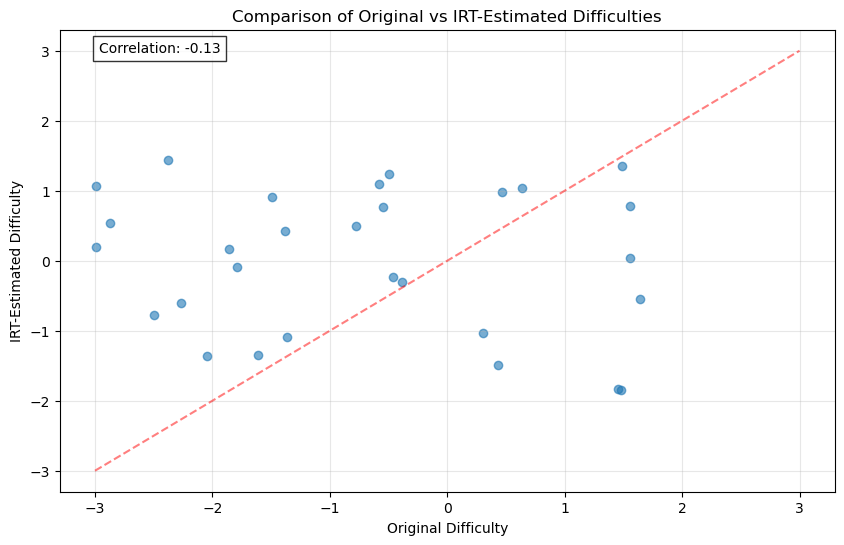


Summary Statistics of Differences:
count    29.000000
mean      1.681005
std       1.166023
min       0.086804
25%       0.684414
50%       1.673345
75%       2.187275
max       4.061784
Name: absolute_difference, dtype: float64

Questions with Largest Discrepancies:
    question_id                                                           question_title  original_difficulty  irt_difficulty  absolute_difference
18        16385  <div>What is the value of `(-1)^3 + (-1)^2 - (-2)^2`?<br><br><br></div>            -2.993787        1.067997             4.061784
13        26315                      Factor the following expression `216a^3+8`:<br><br>            -2.374354        1.444152             3.818506
9         25579      <div>What is the number that multiplied by 2, is equal to 18?</div>            -2.871099        0.543467             3.414566
2         22927                                                            `3641 ÷ 11` =             1.482419       -1.853812             3.336

In [16]:
# Load the original difficulties from selected_questions
original_difficulties = selected_questions['difficulty'].values

# Load the IRT-generated difficulties
irt_difficulties = question_params['irt_difficulty'].values

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'question_id': selected_questions['question_id'],
    'question_title': selected_questions['question_title'],
    'original_difficulty': original_difficulties,
    'irt_difficulty': irt_difficulties
})

# Calculate correlation
correlation = np.corrcoef(original_difficulties, irt_difficulties)[0,1]

print("Correlation between original and IRT difficulties:", correlation)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(original_difficulties, irt_difficulties, alpha=0.6)
plt.plot([-3, 3], [-3, 3], 'r--', alpha=0.5)  # diagonal line for reference
plt.xlabel('Original Difficulty')
plt.ylabel('IRT-Estimated Difficulty')
plt.title('Comparison of Original vs IRT-Estimated Difficulties')
plt.grid(True, alpha=0.3)

# Add correlation coefficient to plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# Calculate absolute differences and add to DataFrame
comparison_df['absolute_difference'] = abs(comparison_df['original_difficulty'] - comparison_df['irt_difficulty'])

# Print summary statistics
print("\nSummary Statistics of Differences:")
print(comparison_df['absolute_difference'].describe())

# Print questions with largest discrepancies
print("\nQuestions with Largest Discrepancies:")
print(comparison_df.nlargest(5, 'absolute_difference')[
    ['question_id', 'question_title', 'original_difficulty', 'irt_difficulty', 'absolute_difference']
].to_string())

# Print questions with smallest discrepancies
print("\nQuestions with Smallest Discrepancies:")
print(comparison_df.nsmallest(5, 'absolute_difference')[
    ['question_id', 'question_title', 'original_difficulty', 'irt_difficulty', 'absolute_difference']
].to_string())

# Save comparison to CSV
comparison_df.to_csv('difficulty_comparison.csv', index=False)
print("\nFull comparison saved to 'difficulty_comparison.csv'")

## Next Steps
1. **Performance Analysis**: Check the distribution of F1 scores across the 50 user models. Evaluate if there's a strong correlation between the number of training samples a user has and the final model performance.
2. **Generalization**: Consider how well these models will generalize to new questions or topics not seen in the training set.
3. **Difficulty Estimation**: If these models accurately simulate student responses, use them to compute question difficulty by querying each synthetic student.
4. **Integration with Real Students**: Compare synthetic responses with real student performance to validate the realism of the simulated data.

This completes the core demonstration of training separate ModernBERT models per user.

In [ ]:
# Filter df_original for question_id 20540
filtered_df = df_original[df_original['question_id'] == 22927]

# Select only the requested columns
result = filtered_df[['answer_id', 'question_id', 'difficulty']]

print("All results:")
print(result.to_string())




In [ ]:
# Load the original difficulties from selected_questions
original_difficulties = selected_questions['difficulty'].values

# Load the IRT-generated difficulties
irt_difficulties = pd.read_csv('question_parameters.csv')['difficulty'].values

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'question_id': selected_questions.index,
    'original_difficulty': original_difficulties,
    'irt_difficulty': irt_difficulties
})

# Calculate correlation
correlation = np.corrcoef(original_difficulties, irt_difficulties)[0,1]

print("Correlation between original and IRT difficulties:", correlation)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(original_difficulties, irt_difficulties, alpha=0.6)
plt.plot([-3, 3], [-3, 3], 'r--', alpha=0.5)  # diagonal line for reference
plt.xlabel('Original Difficulty')
plt.ylabel('IRT-Estimated Difficulty')
plt.title('Comparison of Original vs IRT-Estimated Difficulties')
plt.grid(True, alpha=0.3)

# Add correlation coefficient to plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# Print detailed comparison
print("\nDetailed Comparison (sorted by absolute difference):")
comparison_df['diff'] = abs(comparison_df['original_difficulty'] - comparison_df['irt_difficulty'])
print(comparison_df.sort_values('diff', ascending=False))